# Table of Contents
1. [Imports](#Imports)
2. [Setup of Initial Variables](#setup_init_variables)
3. [Get Bitcoin Logo](#get_btc_logo)
4. [Utility Functions for Data Preprocessing](#util_data_preprocess)
5. [Download Data Sets](#download_datasets)
    - [Extraction of Blockchain Data](#blockchain_data)
    - [Extraction of Macroeconomic Data](#macroecon_data)
    - [Extraction of Exchange Data](#exchange_data)<br><br>
     - [Vizualize Exchange Data](#price_vizualization)
     - [Preprocess Exchange Data](#preprocess_exch_data)
     - [Plot Histogram of Daily Price Changes](#hist_daily_price_ch)<br><br>
    - [Extraction of Global Currencies Exchange Data](#global_curr_exch_data)
    - [Extraction of Sentiment Data](#sentiment_data)<br><br>
7. [Merge of All Data Source](#merge_data_source)
8. [Min-Max Scaling (a.k.a Normalization)](#normalization)
9. [Statistic of Data Prior Training](#statistics)
    - [Visualize the Whole Dataset](#viz_dataset)
    - [Looking for Trends](#sesonality_differentiation)
    - [Pearson Correlation](#pearson_corr)<br><br>
10. [ML Pipeline](#ml_pipeline)
   - [Split Data (Testing, Training Data Sets)](#split_data)
   - [Set Window Length](#win_len_metrics)
   - [Fill Training, Test Data](#fill_training_test)
   - [Load Model](#load_model)
   - [Train Model](#train_model)
   - [Graph Predicted Values with Training Set](#graph_pred_training_set)
   - [Graph Predicted Values with Test Data](#graph_pred_test_set)

### <a name="imports"></a>Imports

In [1]:
import sys
sys.executable # Set python3

from cryptory import Cryptory
import quandl
import time
import datetime

### <a name="setup_init_variables"></a>Setup Initial Variables

In [2]:
from_date="2013-04-28"
to_date=datetime.date.today().strftime("%Y-%m-%d")
my_cryptory = Cryptory(from_date=from_date)
quandl.ApiConfig.api_key = "eJns-j8GmckFnApoFoAE"
split_date = '2018-01-01' 

### <a name="util_data_preprocess"></a> Utility Functions for Data Preprocessing

In [3]:
import seaborn as sns
from cryptory import Cryptory
import datetime
import matplotlib.pyplot as plt
import urllib2 as urllib
import time
import numpy as np
import pandas as pd
from datetime import timedelta
import numpy as np

"""
    Function to make data from blockchain or other sources consistent with btc exchange data
    If data from APIs has data since 2009 we omit those, if no data exist of a date, the previous date value is used
"""
def drop_initial_rows(api, new_col_name, start_date='2013-04-28'):
    # Read data 
    api_range_format= api
    data = pd.read_csv(urllib.urlopen(api_range_format))
    
    # Check if its the Block Size data
    if 'avg' in api:
        # Format columns
        data = pd.DataFrame(data.values, columns=['date', new_col_name])
        data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
        data['date'] = pd.DataFrame(data=data['date'], columns=['date'])

        data['date'] = pd.to_datetime(data['date'])

        # Add dates that do not appear at all, because their blocksize was same as the day before
        data = data.set_index('date').resample('D').ffill()

        # Reset index
        data.index.name='date'
        data = data.reset_index()
        data = data

        # Drop values before 2013, to be consistent with BTC Exchange dataset
        data = data.drop(data[data['date'] < '2013-04-28'].index)
        data = data.reset_index(drop=True)
        return data
        
    else:
        # Get the average block size from blockchain.info; max size ==> 1 MB (by design)
        df = data
        df = pd.DataFrame(df.values, columns=['date', new_col_name])
        df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
        df['date'] = pd.DataFrame(data=df['date'], columns=['date'])
        df['date']=df
        df['date'] = pd.to_datetime(df['date'])
        # Remove rows corresponding to dates before 2013-05-02
        df = df.set_index('date').resample('D').ffill()
        df.index.name='date'
        df.index.names = ['date']
        data = df.reset_index()
        df = data
        df[df['date'] < start_date]

        df = df.drop(df[df['date'] < start_date].index)
        df = df.reset_index(drop=True)
        return df

In [4]:
def rename_columns(prepend_to_name, df):
    df.columns = [df.columns[0]]+ \
                [str(prepend_to_name)+i for i in df.columns[1:]]

### <a name="download_datasets"></a> Download Data Sets

#### <a name="blockchain_data"></a> Extraction of Blockchain Data

In [5]:
# Get the average block size from blockchain.info; max size ==> 1 MB (by design)
block_size_api = "https://blockchain.info/charts/avg-block-size?timespan=all&format=csv" 
avg_block_size = drop_initial_rows(block_size_api, 'avg_block_size')

# Get transactions Daily
txs_api = "https://api.blockchain.info/charts/n-transactions?timespan=all&format=csv" 
txs_data = drop_initial_rows(txs_api, 'transactions')

## Data From Blockchain.info through Quandl API: https://www.quandl.com/data/BCHAIN-Blockchain

# Bitcoin Mining Difficulty
bchain_diff_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/DIFF.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_diff_data = drop_initial_rows(bchain_diff_api, 'difficulty')

# Bitcoin api.blockchain Size
bchain_blchs_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/BLCHS.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_blchs_data = drop_initial_rows(bchain_blchs_api, 'bchain_size')

# Rvenue of Bitcoin Miners
bchain_mirev_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/MIREV.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_mirev_data = drop_initial_rows(bchain_mirev_api, "mining_revenue")

# Bitcoin Hash Rate
bchain_hash_rate_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/CPTRA.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_hash_rate_data = drop_initial_rows(bchain_hash_rate_api, "hash_rate")
                       
# Bitcoin Cost Per Transaction
bchain_cpt_api = "https://www.quandl.com/api/v3/datasets/BCHAIN/NADDU.csv?api_key=55AcwGQK3qwgy8J3K4Pw"
bchain_cpt_data = drop_initial_rows(bchain_cpt_api, "cost_per_transaction")   

blockchain_data = avg_block_size.merge(txs_data, on='date', how='inner'). \
            merge(bchain_diff_data,on='date' ,how='inner'). \
            merge(bchain_blchs_data, on='date', how='inner'). \
            merge(bchain_mirev_data, on='date', how='inner'). \
            merge(bchain_hash_rate_data, on='date', how='inner'). \
            merge(bchain_cpt_data, on='date', how='inner')


In [753]:
# Gist of it
blockchain_data.head()

,date,avg_block_size,transactions,difficulty,bchain_size,mining_revenue,hash_rate,cost_per_transaction
0,2013-04-28,0.126539,40986,8.9743e+06,6820,572110,13.9587,107554
1,2013-04-29,0.126539,40986,8.9743e+06,6844,645240,12.9025,73687
2,2013-04-30,0.185539,48795,1.00763e+07,6870,525693,10.7735,60887
3,2013-05-01,0.185539,48795,1.00763e+07,6892,442507,8.77347,61672
4,2013-05-02,0.189949,57278,1.00763e+07,6918,383775,6.70022,67744


#### <a name="macroecon_data"></a>Extraction of Macroeconomic Data

In [6]:
# S&P 500
s_and_p_stock = my_cryptory.get_stock_prices(market="%5EGSPC")
s_and_p_stock = s_and_p_stock.loc[:,['date', 'close']]
# Rename close column
s_and_p_stock = s_and_p_stock.rename(columns={'close': 'sp_close'})


# Dow and Jones
dow_jones_stock = my_cryptory.get_stock_prices(market="%5EDJI")
dow_jones_stock = dow_jones_stock.loc[:,['date', 'close']]
dow_jones_stock = dow_jones_stock.rename(columns={'close': 'dj_close'})


# Nasdaq
nasdaq_stock = my_cryptory.get_stock_prices(market="%5EIXIC")
nasdaq_stock = nasdaq_stock.loc[:,['date', 'close']]
nasdaq_stock = nasdaq_stock.rename(columns={'close': 'nasdaq_close'})

# Vix
vix_stock = my_cryptory.get_stock_prices(market="%5EVIX")
vix_stock = vix_stock.loc[:,['date', 'close']]
vix_stock = vix_stock.rename(columns={'close': 'vix_close'})

# Commodity Prices
metals_prices = my_cryptory.get_metal_prices()
metals_prices = metals_prices[['date', 'gold_am', 'silver']]

# Oil Price
oil_price = my_cryptory.get_oil_prices()

macro_econ_data = s_and_p_stock.merge(dow_jones_stock,on='date', how='inner') \
                .merge(nasdaq_stock,on='date', how='inner') \
                .merge(vix_stock, on='date', how='inner') \
                .merge(metals_prices,on='date', how='inner') \
                .merge(oil_price, on='date', how='inner')


In [ ]:
# Gist of it
macro_econ_data.head() 

#### <a name="exchange_data"></a> Extraction of Exchange Data

In [48]:
# Daily data from coinmarketcap
coinmarket_btc_market_info = my_cryptory.extract_coinmarketcap("bitcoin")

In [8]:
# Sort coinmarket_btc_market_info
# coinmarket_btc_market_info = coinmarket_btc_market_info.sort_values(by='date')

In [49]:
# Get rid of rows where volume is 0
coinmarket_btc_market_info = coinmarket_btc_market_info[coinmarket_btc_market_info['volume']!=0]
# Drop unnecessary columns
coinmarket_btc_market_info.drop(['marketcap'], axis=1, inplace=True)

In [50]:
# date	open	high	low	close	volume	marketcap

mtgox = pd.read_csv("bitcoinMtGox.csv")

# Drop unnecessary columns
mtgox.drop([0, 1])
mtgox.drop(['Weighted','Volume (BTC)'], axis=1, inplace=True)

# Rename columns
mtgox.columns = ['date', 'open', 'high', 'low', 'close', 'volume']

##### MtGox preprocessing
[Source of data](https://satoshi.camp/stats/mtgoxhistory/usd)

In [51]:
# Remove the '$' sign from price-related columns
for price_col in ['date', 'open', 'high', 'low', 'close', 'volume']:
    mtgox[price_col]=mtgox[price_col].map(lambda x: str(x)[1:] if str(x)[0]=='$' else str(x))

# Remove last row containing: 'satoshi.camp' 
mtgox = mtgox[:-1]

mtgox['date'] = pd.to_datetime(mtgox['date'], format='%Y-%m-%d')

start_date = datetime.date(2013,4,28)
end_date =  datetime.date(2013,12,26)

mtgox_partial_data = mtgox.loc[(pd.to_datetime(mtgox['date']).dt.date >= start_date) & (pd.to_datetime(mtgox['date']).dt.date <= end_date)]

In [56]:
# Merge MtGox data with coinbase exchange
# print(mtgox_partial_data)
# date        open        high         low       close       volume
# date     open     high      low    close      volume     marketcap

# Concatenate MtGox with CoinmarketCap data
frames = [mtgox_partial_data, coinmarket_btc_market_info]

# mtgox_partial_data

# coinmarket_btc_market_info
res=coinmarket_btc_market_info.append(mtgox_partial_data, ignore_index=True)

# result = pd.concat(frames,axis=0)
# print(type(result['open']))
# coinmarket_btc_market_info = coinmarket_btc_market_info.merge(mtgox_partial_data, on='date', how='inner')

In [58]:
coinmarket_btc_market_info=res

##### <a name="price_vizualization"></a>Vizualize Exchange Data

In [59]:
import plotly.plotly as py
import plotly.graph_objs as go

import pandas as pd

# data = [go.Scatter(
#           x=coinmarket_btc_market_info.date,
#           y=coinmarket_btc_market_info['close'])]

# py.iplot(data)

btc_trace_high = go.Scatter(
                x=coinmarket_btc_market_info.date,
                y=coinmarket_btc_market_info['high'],
                name = "Bitcoin High",
                line = dict(color = '#17BECF'),
                opacity = 0.8)

btc_trace_low = go.Scatter(
                x=coinmarket_btc_market_info.date,
                y=coinmarket_btc_market_info['low'],
                name = "Bitcoin Low",
                line = dict(color = '#7F7F7F'),
                opacity = 0.8)

data = [btc_trace_high,btc_trace_low]

layout = dict(
    title = "Levizjet ne Cmimin e Bitcoin",
    xaxis = dict(
        range = ['2013-02-01','2018-09-22'])
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Levizjet ne Cmimin e Bitcoin")

##### <a name="preprocess_exch_data"></a>Preprocess Exchange Data
Some columns were removed to add others, as below:

Removed: 
1. Open Price
2. High
3. Low

Added: 
1. **close_off_high** -> represents the _gap_ between closing price and price high
2. **voltility** -> difference between high and low prices divided by 2 


The data is arranged from earliest to latest
The date column won't be fed to the algorithm



In [534]:
# print (coinmarket_btc_market_info[ pd.to_numeric(coinmarket_btc_market_info['low'], errors='coerce').isnull()])
# pd.to_numeric(coinmarket_btc_market_info['close'], errors='coerce').isna()

# coinmarket_btc_market_info.to_csv('coinmarket_btc_market_info.csv')

In [85]:
############################################################################################
#######
####### Add New Columns
#######
############################################################################################
# coinmarket_btc_market_info = coinmarket_btc_market_info.assign(Date=pd.to_datetime(btc_market_info['date']))
pd.DataFrame(coinmarket_btc_market_info).fillna(coinmarket_btc_market_info.mean())
# Housekeeping

for str_col in ['volume', 'close', 'open', 'low', 'high']:
    coinmarket_btc_market_info[str_col] = coinmarket_btc_market_info[str_col].astype('float')
    coinmarket_btc_market_info[str_col] = coinmarket_btc_market_info[str_col].astype('int64')

coinmarket_btc_market_info.columns = coinmarket_btc_market_info.columns.str.replace("*", "") 

rename_columns('bt_', coinmarket_btc_market_info)

# Calculate new columns
for coins in ['bt_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'close']-x[coins+'open'])/x[coins+'open']}
    coinmarket_btc_market_info = coinmarket_btc_market_info.assign(**kwargs)

for coins in ['bt_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'high']- x[coins+'close'])/(x[coins+'high']-x[coins+'low'])-1,
            coins+'volatility': lambda x: (x[coins+'high']- x[coins+'low'])/(x[coins+'open'])}
    coinmarket_btc_market_info = coinmarket_btc_market_info.assign(**kwargs)

KeyError: 'volume'

##### <a name="hist_daily_price_ch"></a>Plot Histogram of Daily Price Changes

Text(0.5,1,'Bitcoin Daily Price Changes')

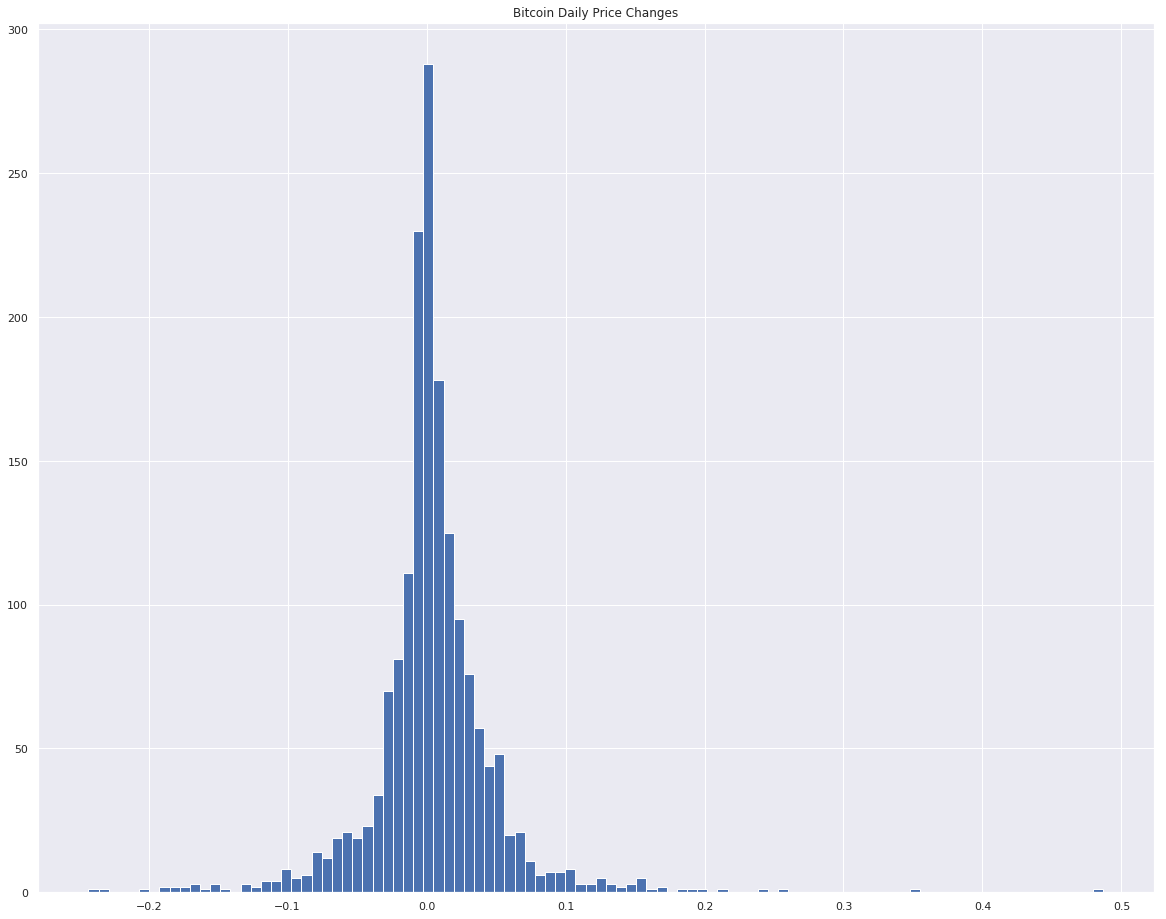

In [86]:
fig, ax1 = plt.subplots()
ax1.hist(coinmarket_btc_market_info[coinmarket_btc_market_info['date']< split_date]['bt_day_diff'].values, bins=100)
ax1.set_title('Bitcoin Daily Price Changes')

#### <a name="global_curr_exch_data"></a> Global Currencies Exchange Data

In [62]:
# USD - EUR
eur_usd_exchange_rate = my_cryptory.get_exchange_rates(from_currency="USD", to_currency="EUR")
eur_usd_exchange_rate = eur_usd_exchange_rate.rename(columns={'exch_rate': 'eur_exch_rate'})

# USD - JPY
jpy_usd_exchange_rate = my_cryptory.get_exchange_rates(from_currency="USD", to_currency="JPY")
jpy_usd_exchange_rate = jpy_usd_exchange_rate.rename(columns={'exch_rate': 'jpy_exch_rate'})

# USD - Yuan
cny_usd_exchange_rate = my_cryptory.get_exchange_rates(from_currency="USD", to_currency="CNY")
cny_usd_exchange_rate = cny_usd_exchange_rate.rename(columns={'exch_rate': 'cny_exch_rate'})


exchange_data = coinmarket_btc_market_info.merge(eur_usd_exchange_rate, on='date', how='inner'). \
            merge(jpy_usd_exchange_rate,on='date' ,how='inner'). \
            merge(cny_usd_exchange_rate, on='date', how='inner')

# Get Rid of data that was included in new columns
exchange_data = exchange_data[['date','eur_exch_rate','jpy_exch_rate','cny_exch_rate']+[coin+metric for coin in ['bt_'] 
                                   for metric in ['close','volume','close_off_high','volatility']]]

In [63]:
exchange_data.head()

,date,eur_exch_rate,jpy_exch_rate,cny_exch_rate,bt_close,bt_volume,bt_close_off_high,bt_volatility
0,2018-09-22,1.1759,0.009147,0.157811,6721,4509660000,-0.060606,0.029399
1,2018-09-21,1.1759,0.009147,0.157811,6734,6531940000,-0.597315,0.045755
2,2018-09-20,1.1769,0.009147,0.157811,6519,4348110000,-0.850746,0.020944
3,2018-09-19,1.1667,0.009147,0.157811,6398,4431340000,-0.583333,0.037671
4,2018-09-18,1.1697,0.009147,0.157811,6371,4180090000,-0.781513,0.018949


#### <a name="sentiment_data"></a>Extraction of Sentiment Data

In [64]:
####################################################################################################################
########
######## Extract Sentiment Data
########
####################################################################################################################
btc_google_trends = my_cryptory.get_google_trends(kw_list=['bitcoin'])
rename_columns('google_trends_', btc_google_trends)

btc_google_trends.head()
# # Leave our reddit for now
# btc_reddit_subscribers = my_cryptory.extract_reddit_metrics(subreddit="bitcoin", 
#                                          metric="total-subscribers")
# rename_columns('reddit_', btc_reddit_subscribers)

,date,google_trends_bitcoin
0,2018-09-21,6.242975
1,2018-09-20,5.107889
2,2018-09-19,5.675432
3,2018-09-18,5.107889
4,2018-09-17,5.675432


### <a name="merge_data_source"></a>Merge of All Data Source

In [206]:
btc_final = exchange_data.merge(btc_google_trends, on='date', how='inner'). \
            merge(blockchain_data,on='date' ,how='inner'). \
            merge(macro_econ_data, on='date', how='inner')

arr = btc_final.columns.values

In [207]:
# need to reverse the data frame so that subsequent rows represent later timepoints
btc_final = btc_final.sort_values(by='date')
# btc_final.reindex(index=btc_final.index[::-1])

print(btc_final)

           date  eur_exch_rate  jpy_exch_rate  cny_exch_rate  bt_close  \
1730 2013-04-28            NaN            NaN            NaN       134   
1731 2013-04-29         1.3113            NaN            NaN       143   
1732 2013-04-30         1.3072       0.010213            NaN       139   
1733 2013-05-01         1.3072       0.010283            NaN       116   
1734 2013-05-02         1.3191       0.010286       0.161077       106   
1735 2013-05-03         1.3114       0.010286       0.160896        98   
1736 2013-05-04         1.3114       0.010286       0.160896       112   
1737 2013-05-05         1.3114       0.010286       0.160896       115   
1738 2013-05-06         1.3107       0.010286       0.160994       112   
1739 2013-05-07         1.3107       0.010104       0.161075       109   
1740 2013-05-08         1.3135       0.010111       0.161342       113   
1741 2013-05-09         1.3142       0.010113       0.161486       112   
1742 2013-05-10         1.2988       0

### <a name="normalization"></a>Min-Max Scaling (a.k.a Normalization)

In [208]:
# NORMALIZE USING MIN-MAX METHOD INSTEAD OF STANDARDIZATION
from sklearn.preprocessing import minmax_scale
import numpy as np
from sklearn.preprocessing import Imputer

btc_final.fillna(btc_final.mean())

mean_imputer = Imputer(missing_values='NaN', strategy='mean', axis=0)

btc_without_date = btc_final.loc[:, btc_final.columns != 'date']

# Train the imputor on the df dataset
mean_imputer = mean_imputer.fit(btc_without_date)

# Apply the imputer to the df dataset
imputed_df = mean_imputer.transform(btc_without_date)

# Get back columns
imputed_df = pd.DataFrame(imputed_df, columns = btc_without_date.columns)

# # From numpy array to numpy list
# all_columns_list = btc_final.columns.values.tolist()

imputed_df[['eur_exch_rate', 'jpy_exch_rate', 'cny_exch_rate', 'bt_close', 'bt_volume', 'bt_close_off_high', 'bt_volatility', 'google_trends_bitcoin', 'avg_block_size', 'transactions', 'difficulty', 'bchain_size', 'mining_revenue', 'hash_rate', 'cost_per_transaction', 'sp_close', 'dj_close', 'nasdaq_close', 'vix_close', 'gold_am', 'silver', 'oil_price']] = \
        minmax_scale(imputed_df[['eur_exch_rate', 'jpy_exch_rate', 'cny_exch_rate', 'bt_close', 'bt_volume', 'bt_close_off_high', 'bt_volatility', 'google_trends_bitcoin', 'avg_block_size', 'transactions', 'difficulty', 'bchain_size', 'mining_revenue', 'hash_rate', 'cost_per_transaction', 'sp_close', 'dj_close', 'nasdaq_close', 'vix_close', 'gold_am', 'silver', 'oil_price']])

# Re add date column
imputed_df['date'] = btc_final['date']

# Order by date
imputed_df["date"] = imputed_df["date"].values[::-1]

btc_final=imputed_df

In [209]:
# Reindex, starting from 0 
btc_final.index = range(len(btc_final))
print(len(btc_final))

1973


### <a name="statistics"></a>Statistic of Data Prior Training

In [210]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set()

#### <a name="viz_dataset"></a> Visualize the Whole Dataset

/home/kejsi/.local/lib/python2.7/site-packages/ipykernel_launcher.py:2: UserWarning:

Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access



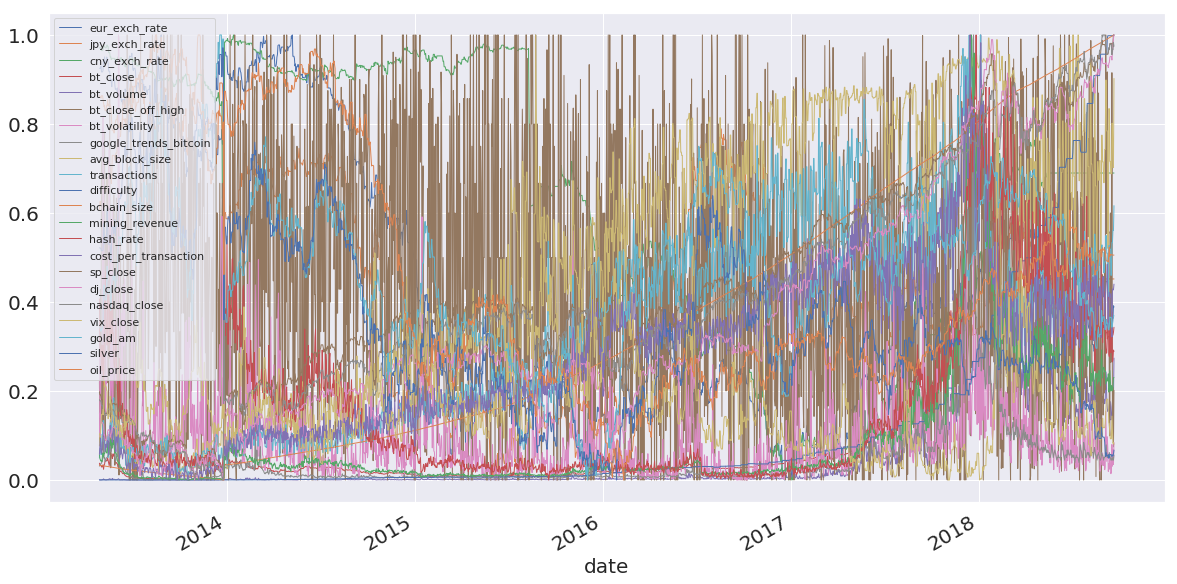

In [211]:
test = btc_final.copy()
test.date_index = pd.to_datetime(test['date'])
test.set_index('date', inplace=True)
test.plot(figsize=(20,10), linewidth=1, fontsize=20)
plt.xlabel('date', fontsize=20);

#### <a name="sesonality_differentiation"></a>Looking for Trends

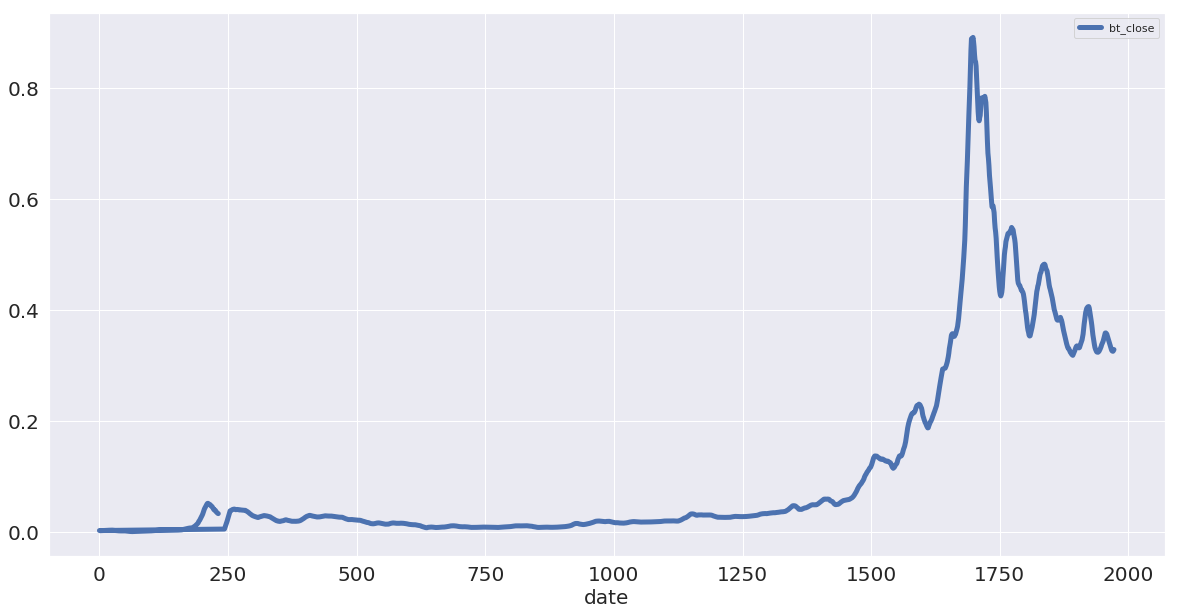

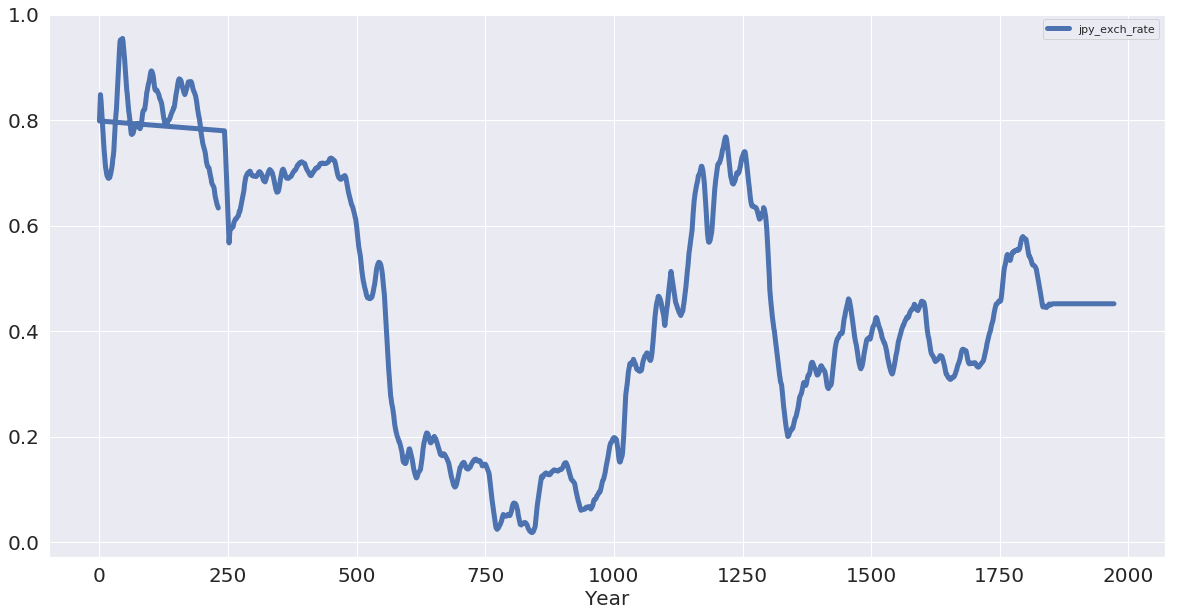

In [212]:
# btc_final=btc_final(['i','j','ColumnA','ColumnB'])
# df = df[['a', 'y', 'b', 'x']]
btc_final = btc_final.sort_values(by='date')
# btc_final.reindex(index=btc_final.index[1::])

# btc_final.set_index('date', inplace=True)

# Trying to get out of the graph up, we check for seasonality
btc_close_price = btc_final[['bt_close']]
btc_close_price.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('date', fontsize=20);

yen = btc_final[['jpy_exch_rate']]
yen.rolling(12).mean().plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.xlabel('Year', fontsize=20);
# need to reverse the data frame so that subsequent rows represent later timepoints

In [213]:
btc_final

,eur_exch_rate,jpy_exch_rate,cny_exch_rate,bt_close,bt_volume,bt_close_off_high,bt_volatility,google_trends_bitcoin,avg_block_size,transactions,...,hash_rate,cost_per_transaction,sp_close,dj_close,nasdaq_close,vix_close,gold_am,silver,oil_price,date
242,0.925048,0.608073,0.970190,0.037779,0.000738,0.221311,0.336106,0.031313,0.076629,0.049755,...,0.406857,0.057949,0.198084,0.150640,0.180447,0.100949,0.342569,0.521505,0.864503,2013-04-28
241,0.925048,0.625785,0.971635,0.032889,0.000139,0.083333,0.096241,0.032398,0.099401,0.070699,...,0.292413,0.080099,0.191675,0.140516,0.178002,0.105696,0.342569,0.521505,0.860831,2013-04-29
240,0.925048,0.625785,0.971635,0.032632,0.000298,0.428571,0.168228,0.034569,0.099401,0.070699,...,0.277582,0.094513,0.191675,0.140516,0.178002,0.105696,0.342569,0.521505,0.860831,2013-04-30
239,0.930064,0.616199,0.969533,0.033198,0.000402,0.127660,0.285576,0.037825,0.075726,0.057247,...,0.288017,0.065486,0.187750,0.135308,0.176647,0.123418,0.333764,0.518817,0.857870,2013-05-01
238,0.916968,0.616199,0.964937,0.029389,0.000304,0.717647,0.258863,0.037825,0.075726,0.057247,...,0.303212,0.058968,0.180627,0.129228,0.167467,0.147152,0.339047,0.515233,0.863674,2013-05-02
237,0.916968,0.616199,0.964937,0.029441,0.000378,0.620253,0.235198,0.041081,0.085167,0.102513,...,0.245862,0.070314,0.180627,0.129228,0.167467,0.147152,0.339047,0.515233,0.863674,2013-05-03
236,0.916968,0.616199,0.964937,0.029955,0.000992,0.810458,0.409611,0.044337,0.085167,0.102513,...,0.282370,0.084510,0.180627,0.129228,0.167467,0.147152,0.339047,0.515233,0.863674,2013-05-04
235,0.920311,0.628634,0.966643,0.034124,0.001230,0.066964,0.815473,0.062788,0.113076,0.133262,...,0.302964,0.093447,0.174204,0.125747,0.157780,0.158544,0.363113,0.516129,0.855265,2013-05-05
234,0.943159,0.668995,0.976898,0.024345,0.002588,0.671756,0.720956,0.095348,0.113076,0.133262,...,0.213139,0.111765,0.174978,0.124828,0.160258,0.147468,0.428857,0.569892,0.845671,2013-05-06
233,0.943159,0.667174,0.976503,0.033301,0.000934,0.637255,0.259980,0.048678,0.095128,0.086396,...,0.284452,0.098050,0.153139,0.100605,0.150617,0.223734,0.438248,0.577061,0.838564,2013-05-07


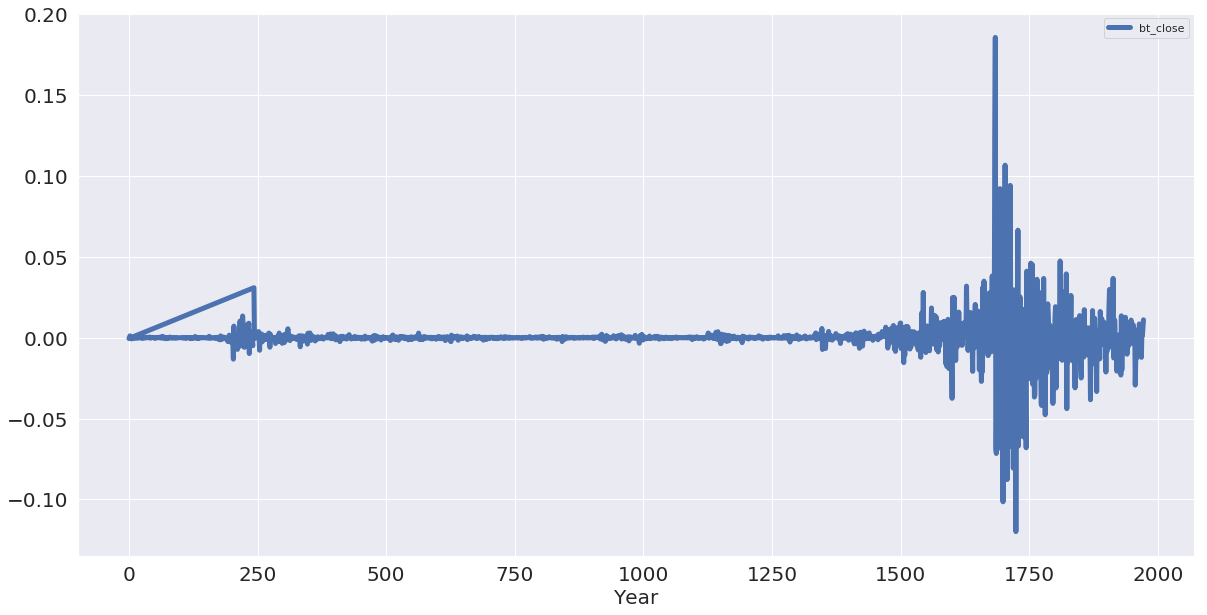

In [214]:
# First Order Differencing
btc_close_price.diff().plot(figsize=(20,10), linewidth=5, fontsize=20)
"""
    Removing the trends seems almost atrocious; The bubbles are very apparent
"""
plt.xlabel('Year', fontsize=20);

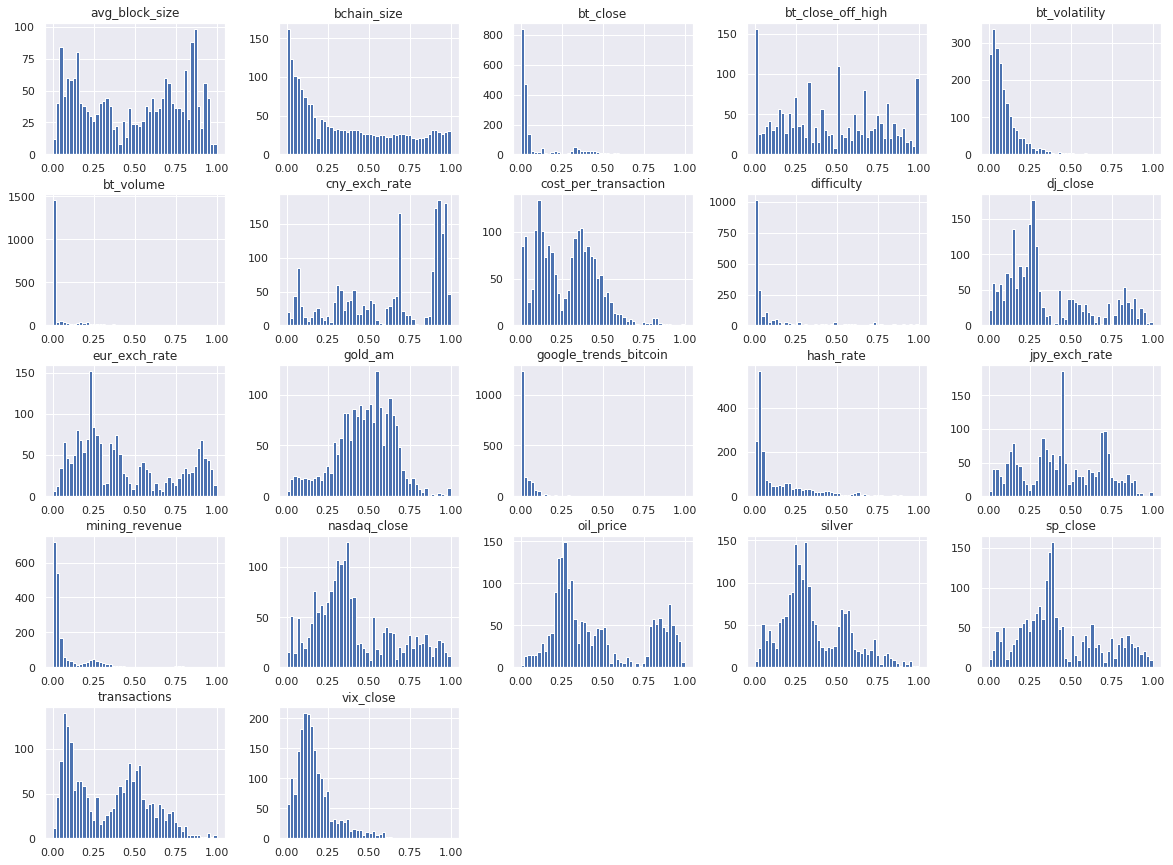

In [713]:
btc_final.hist(bins=50, figsize=(20,15))
# print(all_coins_df)
plt.show()

#### <a name="pearson_corr"></a> Pearson Correlation

In [93]:
# Pearson correlation on all attributes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

"""DROP DATE COLUMN!"""
# btc_final.reset_index()
# btc_final.drop(['date'], 1, inplace=True)
# date column not need for upcoming calculations
all_features_df = btc_final
# btc_final.drop('date', axis=1)
# Percentage change => 
# first calculate: Increase = y_t - y_(t-1) then calculate: %Increace = (Increase-y_(t-1))*100
"""
    %Increase is used both to track the prices of individual securities and 
    of large market indexes, as well as comparing the values of different currencies.  
    Balance sheets with comparative financial statements will generally include the 
    prices of specific assets at different points in time along with the percentage 
    changes over the accompanying periods of time.  
"""
# Compute pairwise correlation of columns, excluding NA/null values
corr = all_features_df.pct_change().corr(method='pearson')
fig, ax = plt.subplots(figsize=(7,5))  
sns.heatmap(corr, 
            xticklabels=[col.replace("_price", "") for col in corr.columns.values],
            yticklabels=[col.replace("_price", "") for col in corr.columns.values],
            annot_kws={"size": 16})
plt.show()


# Table view for readibility
# cmap=sns.diverging_palette(5, 250, as_cmap=True)
cmap=sns.diverging_palette(220, 20, sep=20, as_cmap=True)

def magnify():
    return [dict(selector="th",
                 props=[("font-size", "7pt")]),
            dict(selector="td",
                 props=[('padding', "0em 0em")]),
            dict(selector="th:hover",
                 props=[("font-size", "12pt")]),
            dict(selector="tr:hover td:hover",
                 props=[('max-width', '200px'),
                        ('font-size', '12pt')])
]

corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_caption("Hover to magify")\
    .set_precision(2)\
    .set_table_styles(magnify())

TypeError: ufunc true_divide cannot use operands with types dtype('<M8[ns]') and dtype('<M8[ns]')

### <a name="ml_pipeline"></a> ML Pipeline
#### <a name="split_data"></a> Split Data (Testing, Training Data Sets)

In [215]:
# btc_final.replace(0.0, 0.00001)
training_set, test_set = btc_final[btc_final['date']<split_date], btc_final[btc_final['date']>=split_date]
training_set = training_set.drop('date', 1)
test_set = test_set.drop('date', 1)

In [177]:
print(training_set)

      eur_exch_rate  jpy_exch_rate  cny_exch_rate  bt_close  bt_volume  \
242        0.925048       0.608073       0.970190  0.037779   0.000738   
241        0.925048       0.625785       0.971635  0.032889   0.000139   
240        0.925048       0.625785       0.971635  0.032632   0.000298   
239        0.930064       0.616199       0.969533  0.033198   0.000402   
238        0.916968       0.616199       0.964937  0.029389   0.000304   
237        0.916968       0.616199       0.964937  0.029441   0.000378   
236        0.916968       0.616199       0.964937  0.029955   0.000992   
235        0.920311       0.628634       0.966643  0.034124   0.001230   
234        0.943159       0.668995       0.976898  0.024345   0.002588   
233        0.943159       0.667174       0.976503  0.033301   0.000934   
232        0.950682       0.662812       0.974397  0.035617   0.001347   
231        0.937029       0.647264       0.971241  0.043852   0.000538   
230        0.937029       0.647264    

#### <a name="win_len_metrics"></a> Set Window Length

In [216]:
window_len = 100
norm_cols = ['bt_close','bt_volume']
print(training_set)

      eur_exch_rate  jpy_exch_rate  cny_exch_rate  bt_close  bt_volume  \
242        0.925048       0.608073       0.970190  0.037779   0.000738   
241        0.925048       0.625785       0.971635  0.032889   0.000139   
240        0.925048       0.625785       0.971635  0.032632   0.000298   
239        0.930064       0.616199       0.969533  0.033198   0.000402   
238        0.916968       0.616199       0.964937  0.029389   0.000304   
237        0.916968       0.616199       0.964937  0.029441   0.000378   
236        0.916968       0.616199       0.964937  0.029955   0.000992   
235        0.920311       0.628634       0.966643  0.034124   0.001230   
234        0.943159       0.668995       0.976898  0.024345   0.002588   
233        0.943159       0.667174       0.976503  0.033301   0.000934   
232        0.950682       0.662812       0.974397  0.035617   0.001347   
231        0.937029       0.647264       0.971241  0.043852   0.000538   
230        0.937029       0.647264    

#### <a name="fill_training_test"></a>Fill Training, Test Data

In [197]:
# Fill zero values
training_set[training_set['bt_close_off_high'] == 0] = 0.1
training_set[training_set['bt_close'] == 0] = 0.1
training_set[training_set['eur_exch_rate'] == 0] = 0.1

cols = ['eur_exch_rate','jpy_exch_rate','cny_exch_rate','bt_close', 'bt_volume', 'bt_close_off_high','bt_volatility','google_trends_bitcoin','avg_block_size','transactions','difficulty','bchain_size' ,'mining_revenue','hash_rate','cost_per_transaction','sp_close','dj_close','nasdaq_close','vix_close','gold_am','silver','oil_price']
for i in cols:
    training_set[training_set[i] == 0] = 0.1

In [199]:
# print(np.count_nonzero(training_set==0))
training_set[training_set['eur_exch_rate'] == 0]

,eur_exch_rate,jpy_exch_rate,cny_exch_rate,bt_close,bt_volume,bt_close_off_high,bt_volatility,google_trends_bitcoin,avg_block_size,transactions,...,mining_revenue,hash_rate,cost_per_transaction,sp_close,dj_close,nasdaq_close,vix_close,gold_am,silver,oil_price


In [200]:
LSTM_training_inputs = []
# print(training_set[0:(0+window_len)].copy())
for i in range(len(training_set)-window_len): # 
    temp_set = training_set[i:(i+window_len)].copy()
#     print(temp_set)
    for col in norm_cols:
#         print(temp_set[col])
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
#         print(temp_set[col].iloc[0] - 1)
#         print( temp_set[col])
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['bt_close'][window_len:].values/training_set['bt_close'][:-window_len].values)-1

In [201]:
print(LSTM_training_outputs)

[-0.90326975 -0.88888889 -0.99969355 ...  2.80192859  2.61605389
  2.95508141]


In [202]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['bt_close'][window_len:].values/test_set['bt_close'][:-window_len].values)-1
print(LSTM_test_outputs)

[-4.92236368e-01 -4.75593402e-01 -4.82785964e-01 -4.90180928e-01
 -5.24163355e-01 -5.42356378e-01 -5.22579072e-01 -4.63978281e-01
 -4.33744063e-01 -4.11137202e-01 -3.38157007e-01 -3.72196665e-01
 -3.79932830e-01 -2.97358435e-01 -3.61719148e-01 -1.93398704e-01
 -1.97931655e-01 -1.86393126e-01 -1.89617818e-01 -2.85168732e-01
 -2.15140479e-01 -1.56126300e-01 -1.04166667e-01 -1.46931184e-01
 -1.25189885e-01 -1.36629740e-01 -1.81762223e-01 -2.17784605e-01
 -1.75543285e-01 -1.05897589e-01 -1.75317640e-01 -7.31707317e-02
 -1.22118238e-02 -5.02965078e-02  2.83834815e-02  2.05169159e-01
  4.42362737e-02  8.32781676e-02 -2.19592534e-03 -2.57268113e-02
 -2.37343622e-02 -1.09167597e-02 -1.54549560e-01 -1.18522860e-01
 -2.13664333e-01 -2.78371955e-01 -2.81849484e-01 -3.60105034e-01
 -2.93713632e-01 -3.42296316e-01 -3.44861050e-01 -2.96460177e-01
 -2.37697494e-01 -2.52223199e-01 -2.35915854e-01 -2.11650688e-01
 -2.63449213e-01 -2.85915361e-01 -2.68467422e-01 -3.14251585e-01
 -3.90270467e-01 -4.01278

In [203]:
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

#### <a name="load_model"></a>Load Model


##### For Long Short Term Memory (LSTM)

Theory behind LSTMs: 
- [this](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [this](http://blog.echen.me/2017/05/30/exploring-lstms/)
- [this](http://www.bioinf.jku.at/publications/older/2604.pdf). 


In [204]:
# %load models/lstm_model.py
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import GRU
from keras.layers import Dropout
from keras import optimizers
"""
    If network is overfitting => decrease batch size; the vice-versa for underfitting
"""
# def lstm_model(inputs, output_size, neurons, optimizer="sgd", loss="mae", activ_func="relu",
#                 dropout=0.3): 
def lstm_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):    
    print(inputs.shape[1])
    print(inputs.shape[2])
    
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

#### <a name="train_model"></a>Train Model 

In [205]:
%matplotlib inline
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 10
rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (20, 16)

# Optmizer
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 80
# initialise model architecture
bt_model = lstm_model(LSTM_training_inputs, output_size=pred_range, neurons = 30)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['bt_close'])-pred_range):
    LSTM_training_outputs.append((training_set['bt_close'][i:i+pred_range].values/
                                  training_set['bt_close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: bt_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=30, verbose=2, shuffle=True)

100
22
Epoch 1/50
 - 4s - loss: 416.5785
Epoch 2/50
 - 5s - loss: 416.3438
Epoch 3/50
 - 4s - loss: 416.1748
Epoch 4/50
 - 4s - loss: 415.9843
Epoch 5/50
 - 5s - loss: 415.7909
Epoch 6/50
 - 4s - loss: 415.6253
Epoch 7/50
 - 5s - loss: 415.4814
Epoch 8/50


KeyboardInterrupt: 

#### <a name="graph_pred_training_set"></a>Graph Predicted Values with Training Set

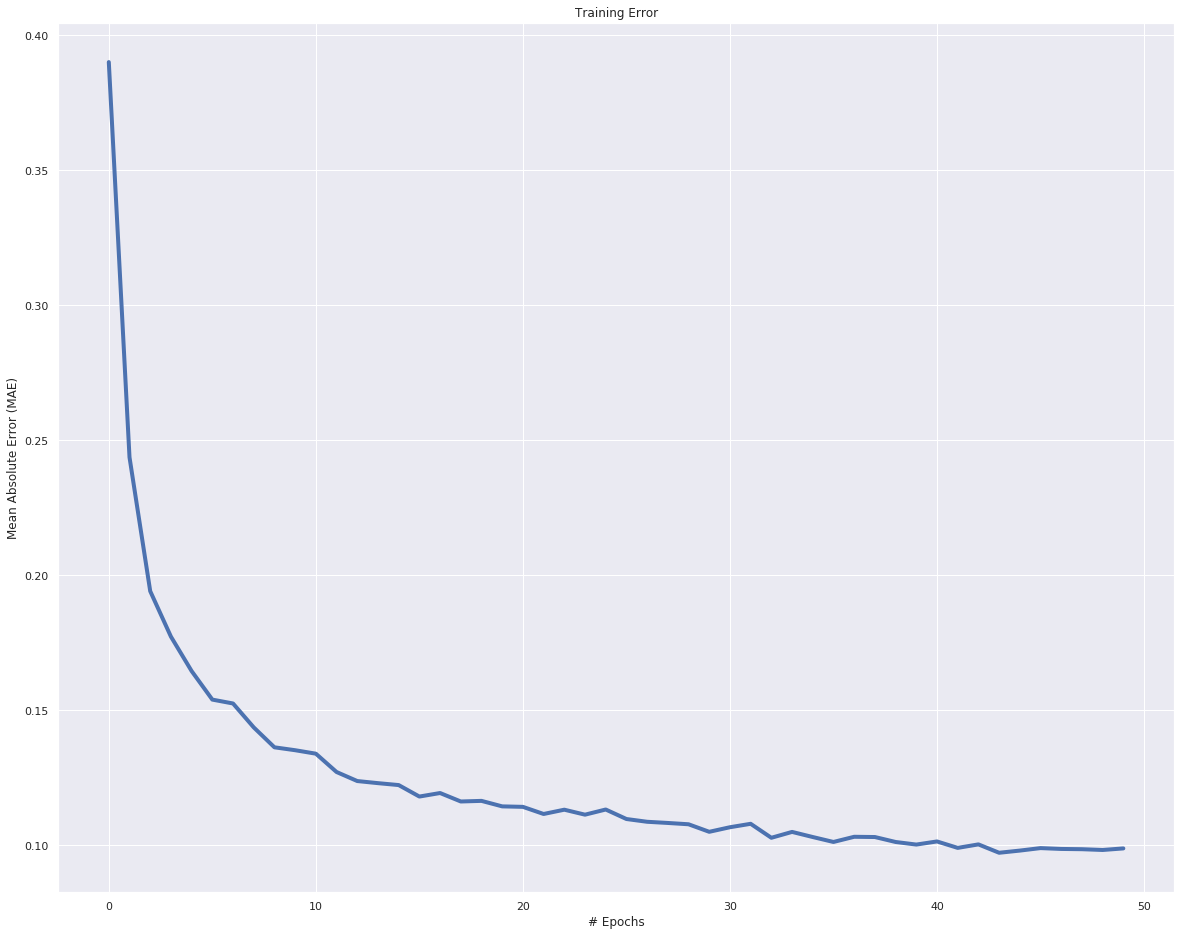

In [45]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(bt_history.epoch, bt_history.history['loss'])
ax1.set_title('Training Error')

if bt_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

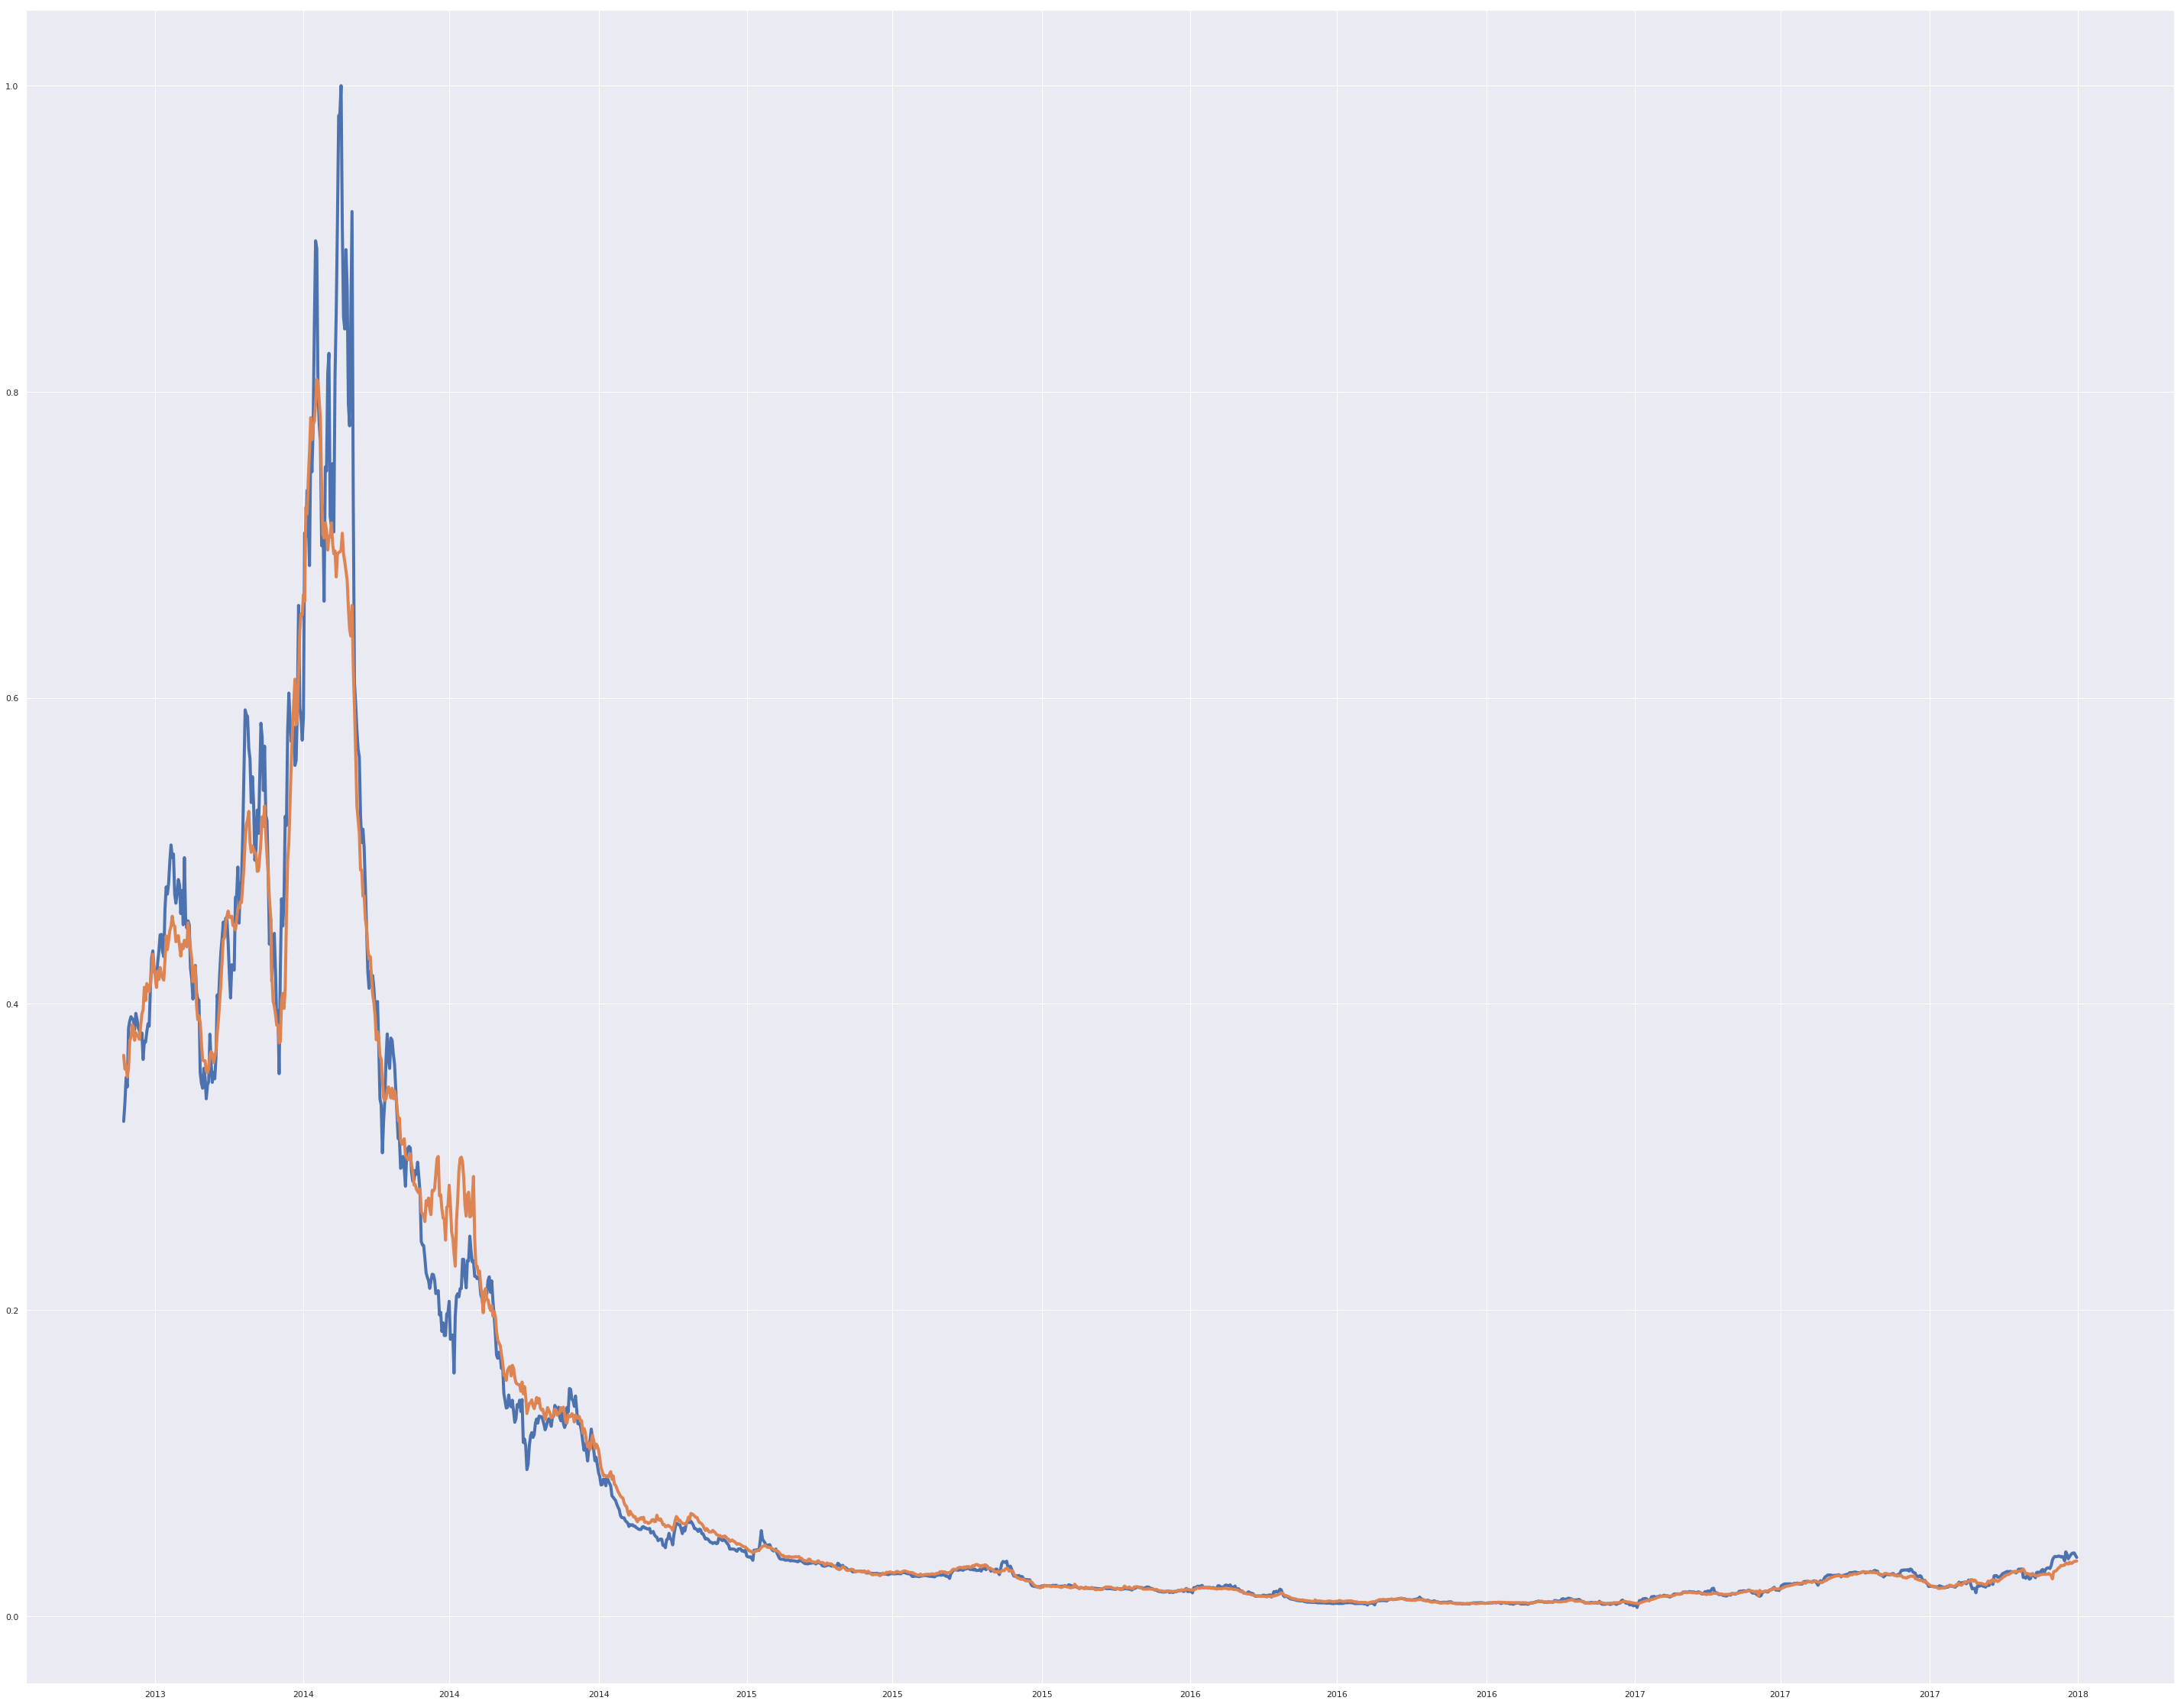

In [46]:
%matplotlib inline
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 10
rcParams['lines.linewidth'] = 4
rcParams['figure.figsize'] = (20, 16)
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2014,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2014,2019) for j in [1,5,9]])

ax1.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         training_set['bt_close'][window_len:], label='Actual')

ax1.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')

ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_close'].values[window_len:])/(training_set['bt_close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 2.52, loc=10, bbox_to_anchor=(400, 307)) # zoom-factor: 2.52, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         training_set['bt_close'][window_len:], label='Actual')
axins.plot(btc_final[btc_final['date']< split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')
# axins.set_xlim([datetime.date(2017, 2, 15), datetime.date(2017, 5, 1)])
# axins.set_ylim([920, 1400])
# mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

#### <a name="graph_pred_test_set"></a> Graph Predicted Values with Test Data

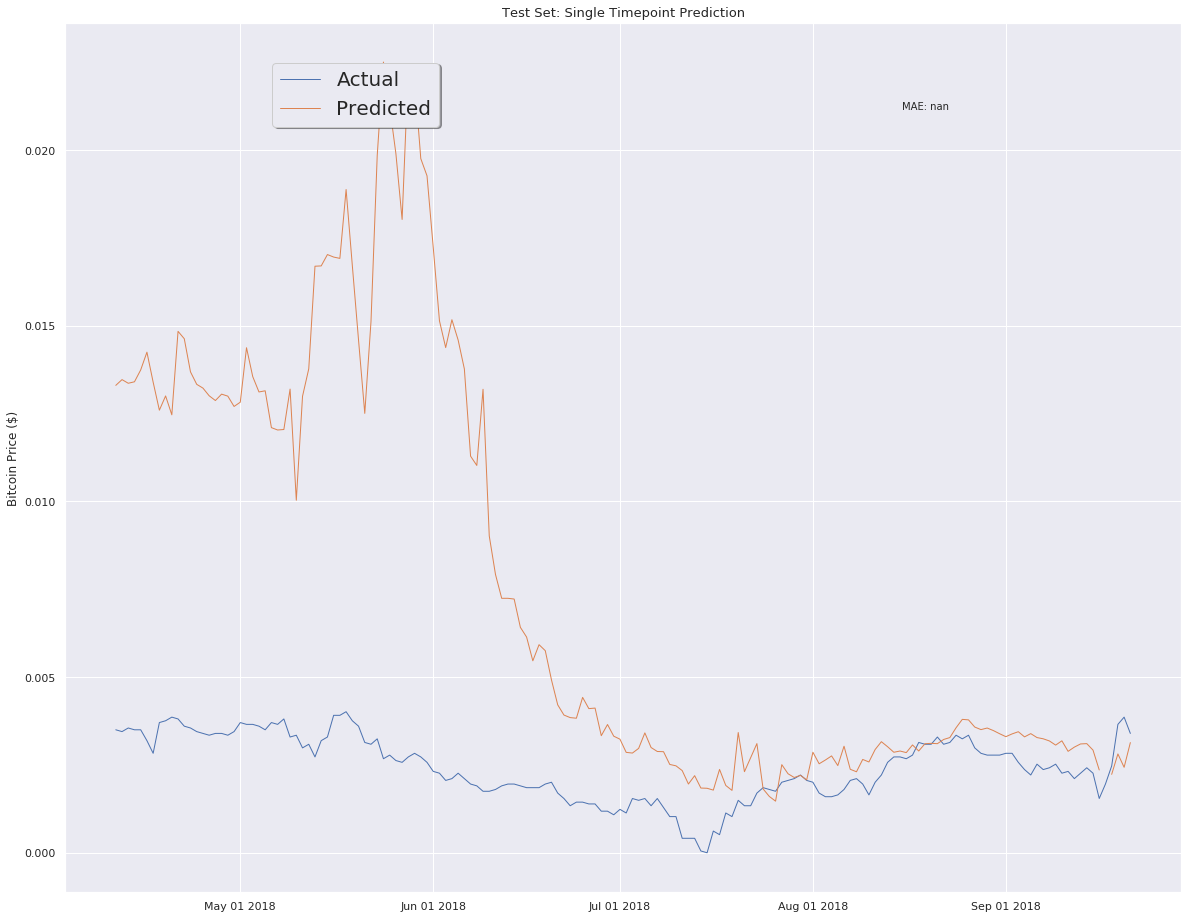

In [47]:
# %matplotlib inline
from matplotlib import rcParams # this module controls the default values for plotting in matplotlib
rcParams['font.size'] = 10
rcParams['lines.linewidth'] = 1
rcParams['figure.figsize'] = (20, 16)

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2018,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2018,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(btc_final[btc_final['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         test_set['bt_close'][window_len:], label='Actual')

ax1.plot(btc_final[btc_final['date']>= split_date]['date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_close'].values[:-window_len])[0], 
         label='Predicted')

ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_close'].values[window_len:])/(test_set['bt_close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=2, prop={'size': 20}, shadow=True)
plt.show()